In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from nilearn.glm.first_level import glover_hrf
from scipy.stats import zscore
from nilearn import datasets
from nilearn.plotting import (plot_anat, plot_epi, plot_roi,
                              plot_glass_brain, plot_stat_map,
                              plot_surf_stat_map, plot_img_on_surf)
from nilearn.image import mean_img, resample_img
from nilearn.surface import vol_to_surf
from nilearn.masking import apply_mask
import nibabel as nib


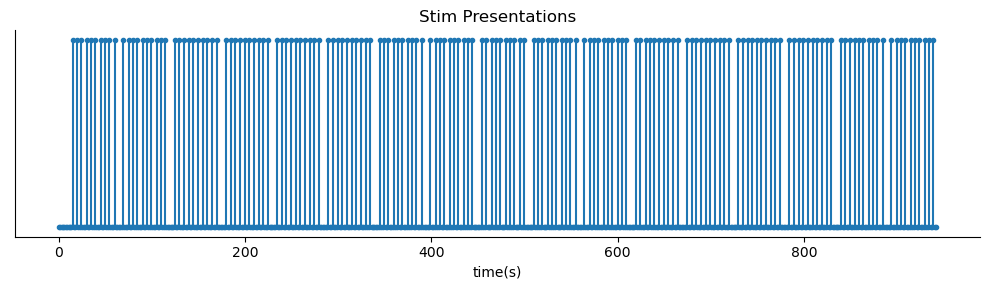

In [7]:
# load stimulus data
stim_df = pd.read_csv('/jukebox/PNI-classes/students/NEU502/2023-NEU502B/wlong/multilang/stimulus_record/780929_502b_project_code_edited_2023-04-05_13h44.30.136.csv')
t_scan_start = stim_df['key_resp.started'][0] + stim_df['key_resp.rt'][0]
stim_df.Language = stim_df.Language.str.split('_', expand=True).to_numpy()
stim_df.stimFile = stim_df.stimFile.str.split('/|_', expand=True).to_numpy()
stim_df.StimFile = stim_df.StimFile.str.split('/|_', expand=True).to_numpy()
stim_df['word'] = stim_df.stimFile

stim_df.loc[stim_df.word.isnull(), 'word'] = stim_df.loc[stim_df.word.isnull(), 'StimFile']
stim_df = stim_df[~stim_df.word.isnull()].reset_index(drop=True)

tr = 1.5
n_trs = 630
time = np.arange(0, n_trs*tr, tr)
stim_trs, _ = np.histogram(stim_df['Sound.started']-t_scan_start, bins=time)  # stims binned into TRs (have not adjusted for if they are presented right at the end of a TR)

fig, ax = plt.subplots(figsize=(10, 3))
ax.stem(time[:-1], stim_trs, markerfmt='.', basefmt='C0')
ax.set_xlabel('time(s)')
ax.set_title('Stim Presentations')
ax.set_yticks([])
plt.tight_layout()
sns.despine()

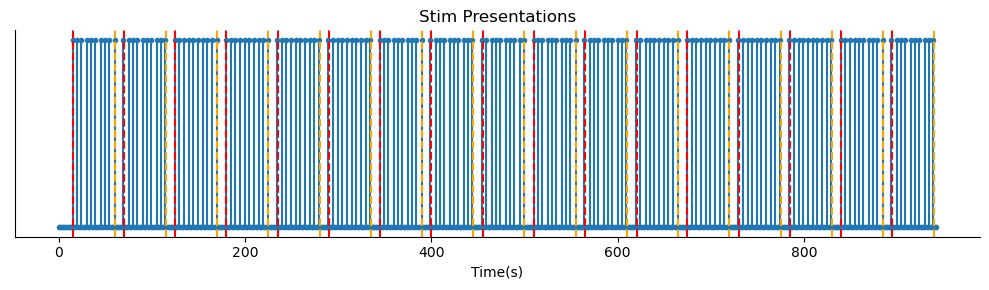

In [75]:
## Detecting start and end time

stim_start = stim_df['Sound.started'].to_numpy() - t_scan_start

block_start_indices = np.where(np.diff(stim_start) > 5.5)[0]

assert len(block_start_indices) == 17 ## Total switches: (3 session * 6 languages) - 1 = 17

block_end_time = stim_start[block_start_indices]
iti_interval = stim_start[block_start_indices + 1] - stim_start[block_start_indices]

block_start_time = (block_end_time + iti_interval)[:-1]
## Insert first stim start at the beginning
block_start_time = np.insert(block_start_time, 0, stim_start[0])
duration = block_end_time - block_start_time

fig, ax = plt.subplots(figsize=(10, 3))
ax.stem(time[:-1], stim_trs, markerfmt='.', basefmt='C0')

for start, end in zip(block_start_time, block_end_time):
    ax.axvline(start, color='red', linestyle='--')
    ax.axvline(end, color='orange', linestyle='--')
ax.set_xlabel('Time(s)')
ax.set_title('Stim Presentations')
ax.set_yticks([])
plt.tight_layout()
sns.despine()

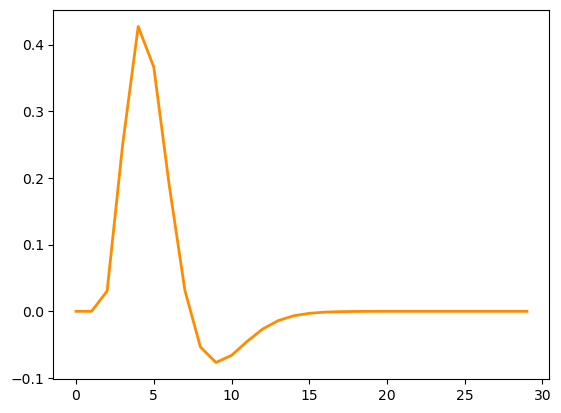

In [85]:
hrf = glover_hrf(tr, time_length = 45, oversampling = 1)
plt.plot(hrf, c='darkorange', lw = 2)

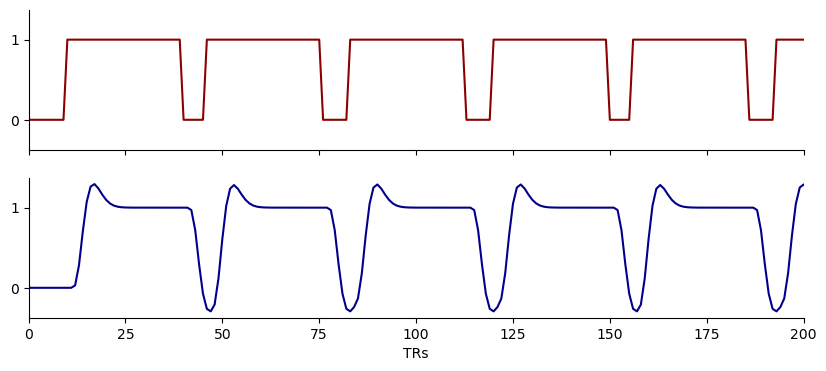

In [99]:
fig, axs = plt.subplots(2, 1, figsize=(10, 4), sharex = True, sharey = True)

stim_arr = np.zeros(n_trs - 1)
for start, end in zip(block_start_time, block_end_time):
    stim_arr[int(start / tr): int(end / tr)] = 1

stim_conv = np.convolve(stim_arr, hrf)[:n_trs - 1]

axs[0].plot(stim_arr, c = "darkred")
axs[0].set_yticks([0, 1])
axs[0].set_xlim(0, 200)

axs[1].plot(stim_conv, c = "darkblue")
axs[1].set_xlabel("TRs")
sns.despine()

### Head motion error

### Component based noise correction method (CompCor)

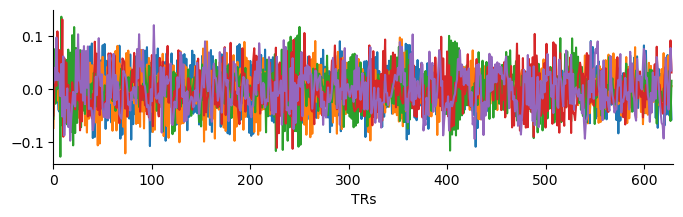

In [45]:
confounds_f = '/jukebox/PNI-classes/students/NEU502/2023-NEU502B/wlong/multilang/data/bids/derivatives/fmriprep/sub-002/ses-01/func/sub-002_ses-01_task-language_desc-confounds_timeseries.tsv'
confounds_df = pd.read_table(confounds_f, sep='\t')

# Extract aCompCor signals from confounds table
acompcor_n = 5
acompcor_df = confounds_df.filter(regex='a_comp_cor').iloc[:, :acompcor_n]
acompcor_labels = acompcor_df.columns.tolist()
acompcor = acompcor_df.values
acompcor = acompcor[: n_trs-1,:]

# Plot aCompCor regressors:
fig, ax = plt.subplots(figsize=(8, 2))
ax.plot(np.arange(n_trs-1), acompcor)
ax.set(xlim=(0, n_trs - 1), xlabel='TRs')
sns.despine()

data shape: (78, 78, 54, 630)


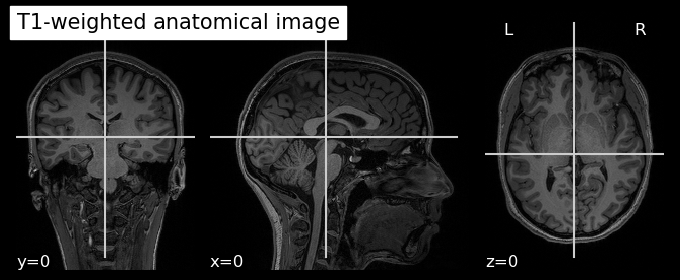

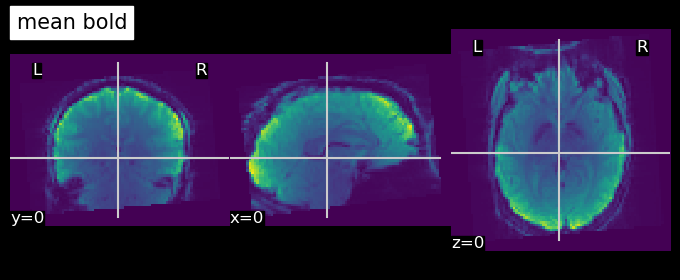

In [46]:
# load fmri data
data_path = '/jukebox/PNI-classes/students/NEU502/2023-NEU502B/wlong/multilang/data/bids/'
func_path = os.path.join(data_path, 'sub-002/ses-01/func/sub-002_ses-01_task-language_bold.nii.gz')
anat_path = os.path.join(data_path, 'sub-002/ses-01/anat/sub-002_ses-01_T1w.nii.gz')
cut_coords = (0, 0, 0)

# Plot the anatomical image
plot_anat(anat_path, cut_coords=cut_coords, title='T1-weighted anatomical image');

plot_epi(mean_img(func_path), cut_coords=cut_coords, cmap='viridis', title='mean bold');
func_data = nib.load(func_path).get_fdata()
n_trs = func_data.shape[3]
print('data shape:', func_data.shape)

(91, 109, 91)


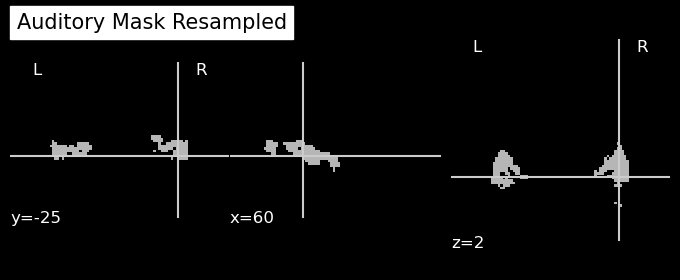

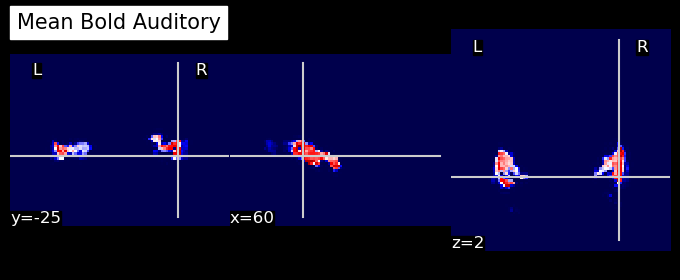

In [47]:
# get auditory mask
# source of auditory mask: https://github.com/ThomasYeoLab/CBIG/tree/master/stable_projects/brain_parcellation/Schaefer2018_LocalGlobal/Parcellations/MNI
# left hemisphere aud is 137-146 inclusive. right hem is 336-344. if you change the parcel file, you will need to go the the 
aud = np.hstack((np.arange(137, 147), np.arange(336, 345)))
masker_path = 'Schaefer2018_400Parcels_Kong2022_17Networks_order_FSLMNI152_2mm.nii.gz'
cut_coords = (60, -25, 2)
aud_masker = nib.load(masker_path)
aud_masker_data = aud_masker.get_fdata()
print(aud_masker_data.shape)
aud_masker_data = np.where(np.isin(aud_masker_data, aud), 1., 0)
aud_masker_img = nib.Nifti1Image(aud_masker_data, affine=aud_masker.affine)

# resample mask to match functional data
func_img = nib.load(func_path)
masker = resample_img(aud_masker_img, func_img.affine, target_shape=func_data.shape[:3], interpolation='nearest')
mask_aud = func_data.transpose(3, 0, 1, 2) * masker.get_fdata()  #using the apply mask function wasn't working at first
mask_aud = nib.Nifti1Image(mask_aud.transpose(1, 2, 3, 0), affine=func_img.affine)
plot_anat(masker, cut_coords=cut_coords, title='Auditory Mask Resampled');
plot_epi(mean_img(mask_aud), cut_coords=cut_coords, cmap='seismic', title='Mean Bold Auditory');

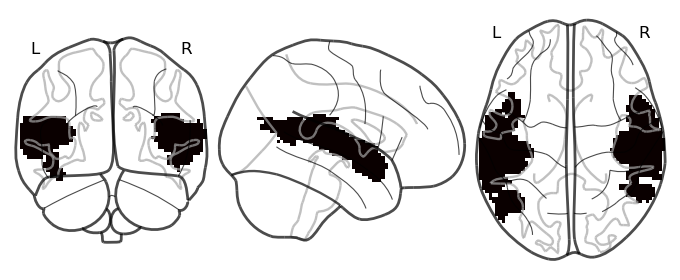

In [48]:
plot_glass_brain(masker);

In [101]:
# get n_times x n_voxels array of fmri signal within auditory cortex over time
bold_masked = func_data[masker.get_fdata().astype(bool)].T
print('masked data shape:', bold_masked.shape)

Y = zscore(bold_masked[:n_trs-1], axis=0)
X = np.vander(stim_conv, N=2, increasing=True)
X = np.hstack((X, acompcor))

masked data shape: (630, 2913)


In [102]:
# Run regression with basic OLS
b, _, _, _ = np.linalg.lstsq(X, Y, rcond=-1)
print('beta shape:', b.shape)

# Make beta coefficient brain map
beta_map = np.zeros(masker.shape)
mask_coords = np.where(masker.get_fdata() == 1)
beta_map[mask_coords] = b[1]

# Convert zero values to NaNs for plotting
beta_map[beta_map == 0] = np.nan

beta_img = nib.Nifti1Image(beta_map, affine=masker.affine)

beta shape: (7, 2913)


/usr/people/tt1131/.conda/envs/neu502b/lib/python3.10/site-packages/nilearn/_utils/niimg.py:63: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(


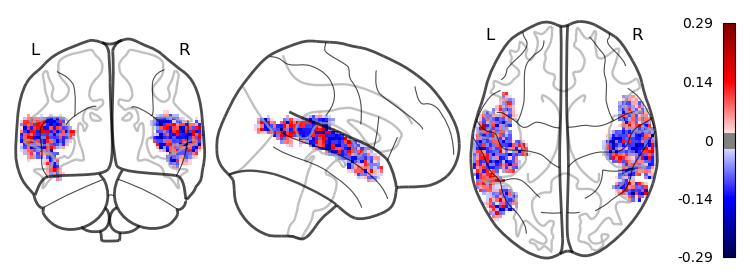

In [103]:
plot_glass_brain(beta_img, colorbar=True, cmap='seismic', threshold=0.02, 
                 plot_abs=False);

<AxesSubplot: >

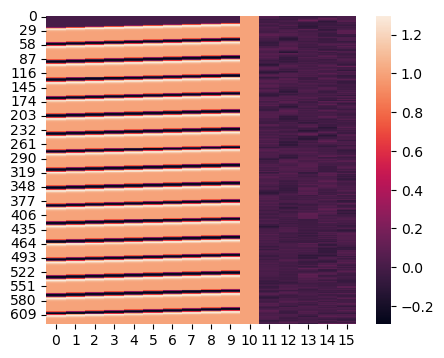

In [104]:
# time lagged regression
from scipy.linalg import hankel

filt_len = 10
padded_stim = np.pad(stim_conv, (filt_len-1, 0), constant_values=(0, 0))
X = hankel(padded_stim[:-filt_len+1], 
           padded_stim[-filt_len:])
X = np.hstack((X, np.ones((X.shape[0], 1))))
X = np.hstack((X, acompcor))
fig, axs = plt.subplots(1, 1, figsize=(5, 4))
sns.heatmap(X, ax=axs)

beta shape: (16, 2913)


/usr/people/tt1131/.conda/envs/neu502b/lib/python3.10/site-packages/nilearn/_utils/niimg.py:63: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(


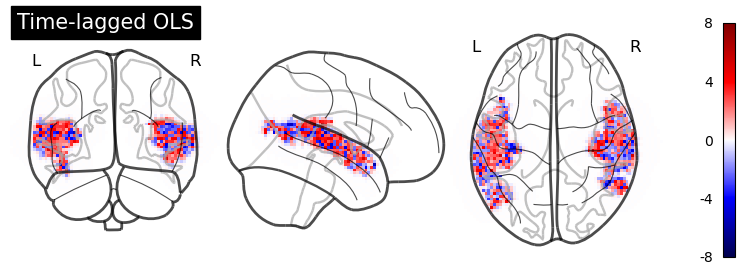

In [105]:
# Run regression with basic OLS
b, _, _, _ = np.linalg.lstsq(X, Y, rcond=-1)
print('beta shape:', b.shape)

# Make beta coefficient brain map
beta_map = np.zeros(masker.shape)
mask_coords = np.where(masker.get_fdata() == 1)
beta_map[mask_coords] = b[1]

# Convert zero values to NaNs for plotting
beta_map[beta_map == 0] = np.nan

beta_img = nib.Nifti1Image(beta_map, affine=masker.affine)

plot_glass_brain(beta_img, colorbar=True, cmap='seismic', 
                 plot_abs=False, title='Time-lagged OLS');